# Figure 5 Linear Fits to $\Delta\!$ MLT a Comparison with Østgaard et al (2004)

In this notebook we show how we perform the linear fits to $\Delta\!$ MLT for the two initial selections of datasets to the mean IMF By and Østgaard et al (2004) to IMF By from their paper
This notebook produces Figure 5 in the related paper.

## Imports
First we import the functions we need

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, iqr
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import t
from Subplot_alignment_tools import subplot_align
tinv = lambda p, df: abs(t.ppf(p/2, df))
import itertools

## Load Selection 1

In [2]:
Sel1= pd.read_csv('./Selection1.csv', index_col=0)
Sel1= Sel1[Sel1.flag==1][['Date_NH', 'Frey_MLT', 'Frey_MLAT', 'Date_SH', 'MLT_SH', 'MLAT_SH']]
Sel1['Date_UTC']= Sel1.Date_NH.values.astype('datetime64[m]')
Sel1.loc[Sel1.Frey_MLT<12, 'Frey_MLT']+=24
Sel1.loc[Sel1.MLT_SH<12, 'MLT_SH']+=24
Sel1['DMLT']= Sel1['MLT_SH']-Sel1['Frey_MLT']

## Load Selection 2

In [3]:
Sel2= pd.read_csv('./Selection2.csv', index_col=0)
Sel2= Sel2[Sel2.flag==1][['Date_NH', 'Frey_MLT', 'Frey_MLAT', 'Date_SH', 'MLT_SH', 'MLAT_SH']]
Sel2['Date_UTC']= Sel2.Date_NH.values.astype('datetime64[m]')
Sel2.loc[Sel2.Frey_MLT<12, 'Frey_MLT']+=24
Sel2.loc[Sel2.MLT_SH<12, 'MLT_SH']+=24
Sel2['DMLT']= Sel2['MLT_SH']-Sel2['Frey_MLT']


## Load Østgaard et al (2004)

In [4]:
Østgaard = pd.read_csv('./Østgaard_2004.csv', index_col=0, parse_dates=['Date_UTC'])
Østgaard['Clock_Angle_ACE']= np.rad2deg(Østgaard.Clock_Angle_ACE)%360

## Loading Omni
Load the omni data and set values to 'NaN' when the required number of data points in the window is not satisfied.

In [5]:
omni= pd.read_hdf('./omni_data.hdf5', key='omni_window_2h_20')
omni.loc[omni['points']<120*.9, ['BX_GSE_Mean','BY_GSM_Mean',
                                 'BZ_GSM_Mean','Clock_GSM_SEM',
                                 'Clock_GSM_Mean']]=np.nan
omni['Date_UTC']= omni.index.values
omni.index= list(range(len(omni)))

## Merging Omni and Onset dataframes using the time column

In [6]:
Sel1=Sel1.merge(omni[['Date_UTC', 'BY_GSM', 'BY_GSM_Mean', 'Clock_GSM_Mean']], on='Date_UTC')

Sel2=Sel2.merge(omni[['Date_UTC', 'BY_GSM', 'BY_GSM_Mean', 'Clock_GSM_Mean']], on='Date_UTC')

## Converting Clock Angle to Degrees

In [7]:
Sel1['Clock_GSM_Mean']= np.rad2deg(Sel1.Clock_GSM_Mean)%360
Sel2['Clock_GSM_Mean']= np.rad2deg(Sel2.Clock_GSM_Mean)%360

## Handling Outliers
We use 1.5 times the interquartile range over and under the upper and lower quartiles to define outliers and create a boolean that is False for outliers

In [8]:
upper_lim= Sel1.DMLT<np.quantile(Sel1.DMLT, .75)+iqr(Sel1.DMLT)*1.5
lower_lim= Sel1.DMLT>np.quantile(Sel1.DMLT, .25)-iqr(Sel1.DMLT)*1.5
rm_out1= upper_lim&lower_lim

upper_lim= Sel2.DMLT<np.quantile(Sel2.DMLT, .75)+iqr(Sel2.DMLT)*1.5
lower_lim= Sel2.DMLT>np.quantile(Sel2.DMLT, .25)-iqr(Sel2.DMLT)*1.5
rm_out2= upper_lim&lower_lim

## Linear Fit to IMF By

In [9]:
x, y= Sel1[rm_out1].BY_GSM_Mean.values, Sel1[rm_out1].DMLT.values
ind= np.isfinite(x)&np.isfinite(y)
L_Sel1_By= linregress(x[ind], y[ind])

ts_Sel1 = tinv(0.1, len(x)-2)


x, y= Sel2[rm_out2].BY_GSM_Mean.values, Sel2[rm_out2].DMLT.values
ind= np.isfinite(x)&np.isfinite(y)
L_Sel2_By= linregress(x[ind], y[ind])
ts_Sel2 = tinv(0.1, len(x)-2)



L_Øst_By= linregress(Østgaard.IMFByACE.values, Østgaard.DMLT.values)

ts_Øst = tinv(0.1, len(x)-2)

## Linear Fit to Clock Angle

In [10]:
x, y= Sel1[rm_out1].Clock_GSM_Mean.values, Sel1[rm_out1].DMLT.values
ind= np.isfinite(x)&np.isfinite(y)
L_Sel1_Clock= linregress(x[ind], y[ind])

x, y= Sel2[rm_out2].Clock_GSM_Mean.values, Sel2[rm_out2].DMLT.values
ind= np.isfinite(x)&np.isfinite(y)
L_Sel2_Clock= linregress(x[ind], y[ind])

L_Øst_Clock= linregress(Østgaard.Clock_Angle_ACE.values, Østgaard.DMLT.values)

## Plotting
First we set the defaults for plotting

In [11]:
colors= ['#003f5c', '#bc5090', '#ffa600']
s=10
xlim= (-15, 15)
ylim= np.nanmax(np.abs([np.min([*Sel1.DMLT.values, *Sel2.DMLT.values, *Østgaard.DMLT.values])*1.1, 
       np.nanmax([*Sel1.DMLT.values, *Sel2.DMLT.values, *Østgaard.DMLT.values])*1.1]))
ylim= (-ylim, ylim)


### Creating Figure

In [12]:
fig= plt.figure( figsize=(15, 5))
fig.suptitle('IMF Dependence of $\Delta$MLT Østgaard et al (2004) Comparison')

Text(0.5, 0.98, 'IMF Dependence of $\\Delta$MLT Østgaard et al (2004) Comparison')

<Figure size 1500x500 with 0 Axes>

### Creating By Subplot

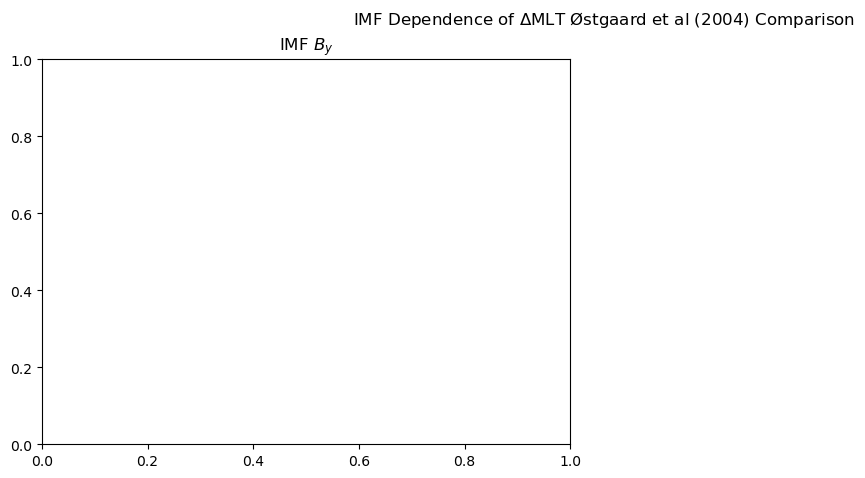

In [13]:
ax= fig.add_subplot(121)
ax.set_title('IMF $B_y$')
fig

#### Scatter Data points

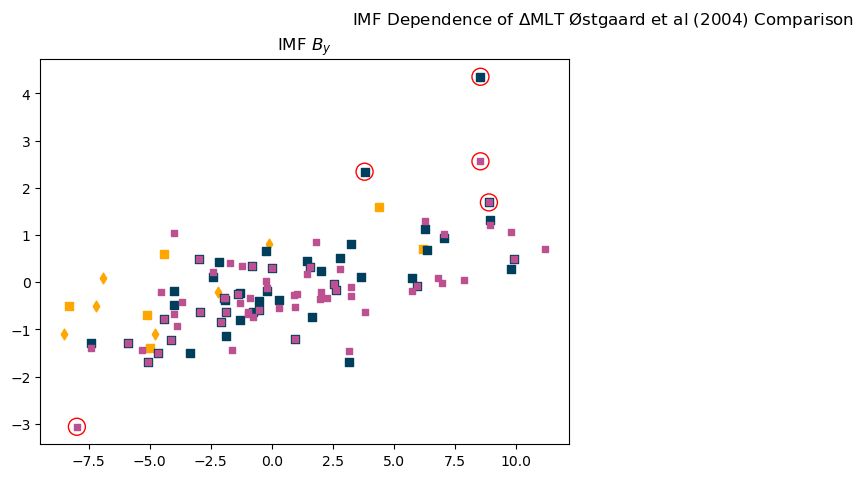

In [14]:
ax.scatter(Sel1[~rm_out1].BY_GSM_Mean, Sel1[~rm_out1].DMLT, marker= 'o', facecolors='none', edgecolors='r', label='Outliers', s=s*15, zorder=100)
ax.scatter(Sel2[~rm_out2].BY_GSM_Mean, Sel2[~rm_out2].DMLT, marker= 'o', facecolors='none', edgecolors='r', s=s*15, zorder=100)

ax.scatter(Sel1.BY_GSM_Mean, Sel1.DMLT, label='Onsets Selection 1', marker='s', color=colors[0], s=s*4, zorder=101)
ax.scatter(Sel2.BY_GSM_Mean, Sel2.DMLT, label='Onsets Selection 2', marker='s', color=colors[1], s=s*1.5, zorder=101)
ind= Østgaard.Type=='Onset                      '
ax.scatter(Østgaard[ind].IMFByACE, Østgaard[ind].DMLT, label='Onsets Østgaard et al (2004)', marker='s', color=colors[2], s=s*3, zorder=80)
ax.scatter(Østgaard[~ind].IMFByACE, Østgaard[~ind].DMLT, label='Auroral Features Østgaard et al (2004)', marker='d', color=colors[2], s=s*3, zorder=80)

fig

#### Plotting Linear Fits and Confidence Intervals
##### Selection 1

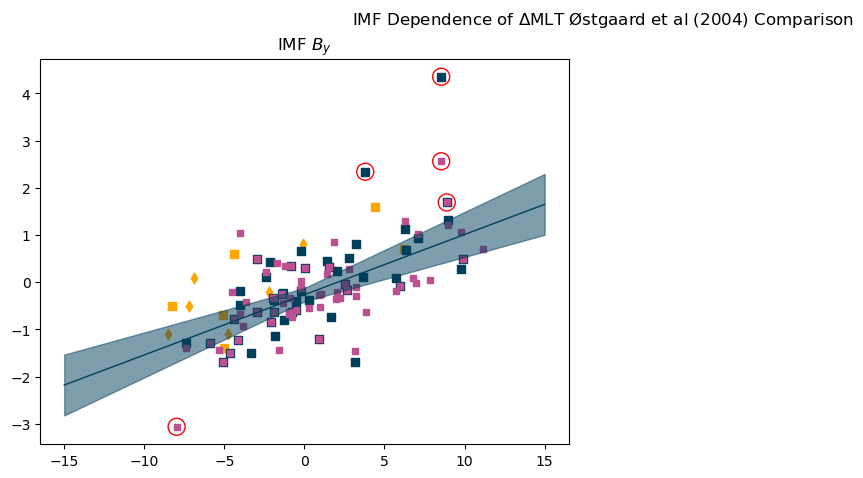

In [15]:
L= L_Sel1_By
ts= ts_Sel1
txt_sel1= f'{np.round(L.slope, 3)}'+r'$B_y$'+ f'{np.round(L.intercept, 3):+}'
ax.plot(np.linspace(*xlim, 100), L.slope*np.linspace(*xlim, 100) +L.intercept, 
        linestyle='-', lw=1, label='Selection 1:\n'+ txt_sel1, color= colors[0], zorder=1000)
      
y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])
ax.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[0], alpha=.5, zorder=110)




fig

##### Selection 2

In [16]:
L= L_Sel2_By
ts= ts_Sel2
txt_sel2= f'{np.round(L.slope, 3)}'+r'$B_y$'+ f'{np.round(L.intercept, 3):+}'
ax.plot(np.linspace(*xlim, 100), L.slope*np.linspace(*xlim, 100) +L.intercept,
        linestyle='-', lw=1, label='Selection 2:\n'+ txt_sel2, color= colors[1], zorder=1000)

y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])
ax.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[1], alpha=.5, zorder=110)


Østgaard et al (2004)

In [17]:
L= L_Øst_By
ts= ts_Øst
txt_Øst= f'{np.round(L.slope, 3)}'+r'$B_y$'+ f'{np.round(L.intercept, 3):+}'
ax.plot(np.linspace(*xlim, 100), L.slope*np.linspace(*xlim, 100) +L.intercept, 
        linestyle='-', lw=1, label= 'Østgaard et al (2004):\n'+ txt_Øst, color= colors[2], zorder=999)

y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])
ax.plot(np.linspace(*xlim, 100), np.vstack([np.min(y, axis=0), np.max(y, axis=0)]).T, linestyle='--', color=colors[2], zorder=999)


#### Add zero lines and set x and y limits

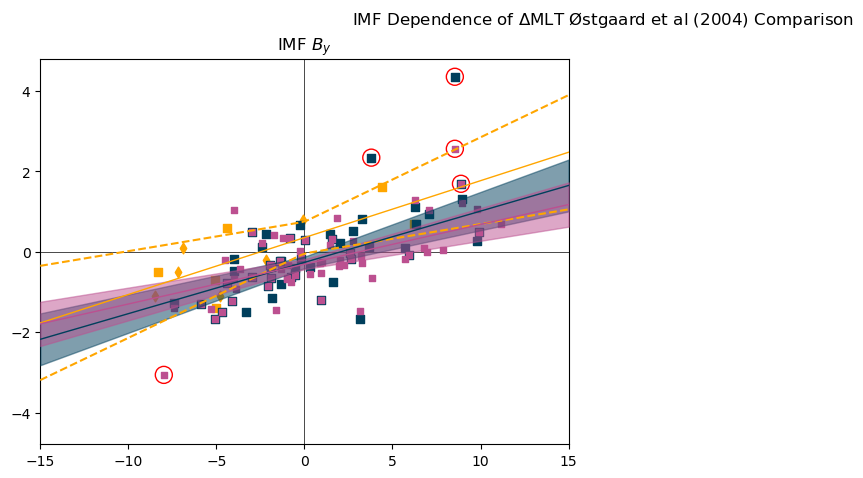

In [18]:
ax.axhline(0, color='black', lw=.5, zorder=-1)
ax.axvline(0, color='black', lw=.5, zorder=-1)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
fig

### Creating Clock Angle Subplot

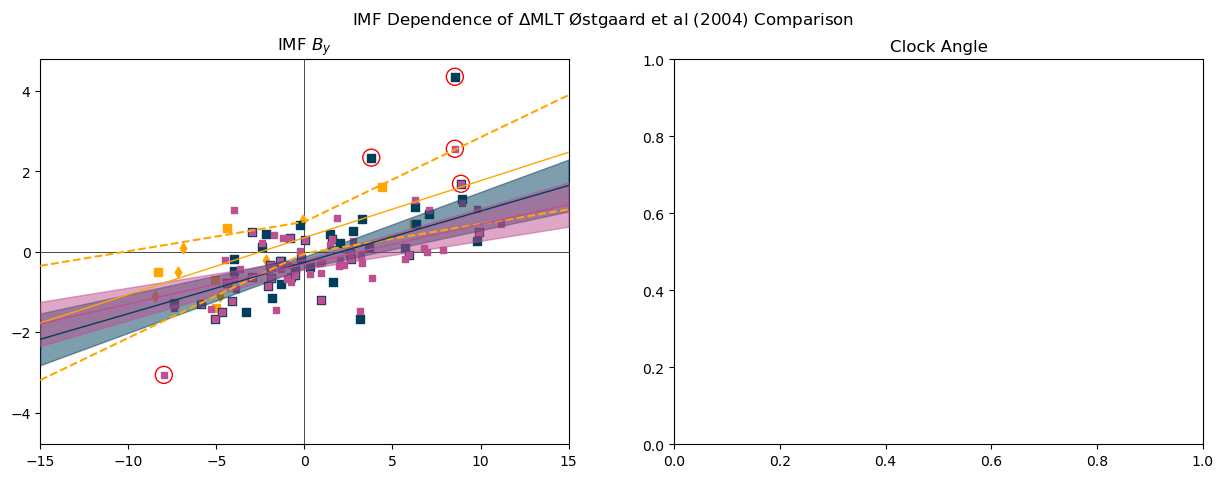

In [19]:
xlim= (0, 360)
ylim= (-5, 5)
ax2= fig.add_subplot(122)
ax2.set_title('Clock Angle')

fig

#### Scatter Data points

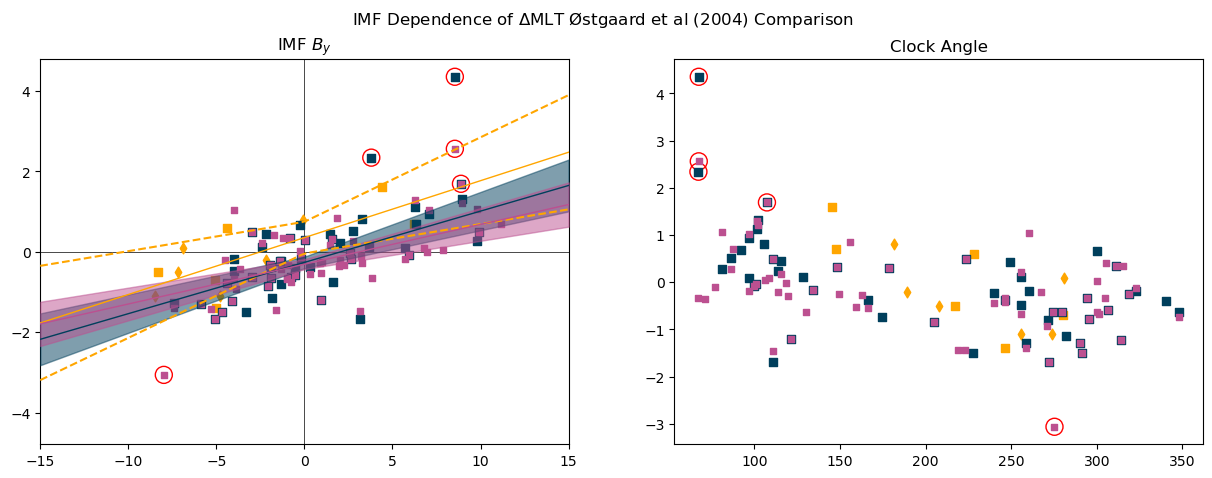

In [20]:
ax2.scatter(Sel1[~rm_out1].Clock_GSM_Mean, Sel1[~rm_out1].DMLT, marker= 'o', facecolors='none', edgecolors='r', 
            label='Outliers', s=s*15, zorder=100)
ax2.scatter(Sel2[~rm_out2].Clock_GSM_Mean, Sel2[~rm_out2].DMLT, marker= 'o', facecolors='none', edgecolors='r', s=s*15, zorder=100)

ax2.scatter(Sel1.Clock_GSM_Mean, Sel1.DMLT, label='Onsets Selection 1', marker='s', color=colors[0], s=s*4,
            zorder=101)
ax2.scatter(Sel2.Clock_GSM_Mean, Sel2.DMLT, label='Onsets Selection 2', marker='s', color=colors[1], s=s*1.5,
            zorder=101)
ind= Østgaard.Type=='Onset                      '
ax2.scatter(Østgaard[ind].Clock_Angle_ACE, Østgaard[ind].DMLT, label='Onsets Østgaard et al (2004)', marker='s', 
            color=colors[2], s=s*3, zorder=80)
ax2.scatter(Østgaard[~ind].Clock_Angle_ACE, Østgaard[~ind].DMLT, label='Auroral Features Østgaard et al (2004)', 
            marker='d', color=colors[2], s=s*3, zorder=80)
fig

#### Plotting Linear Fits and Confidence Intervals
##### Selection 1

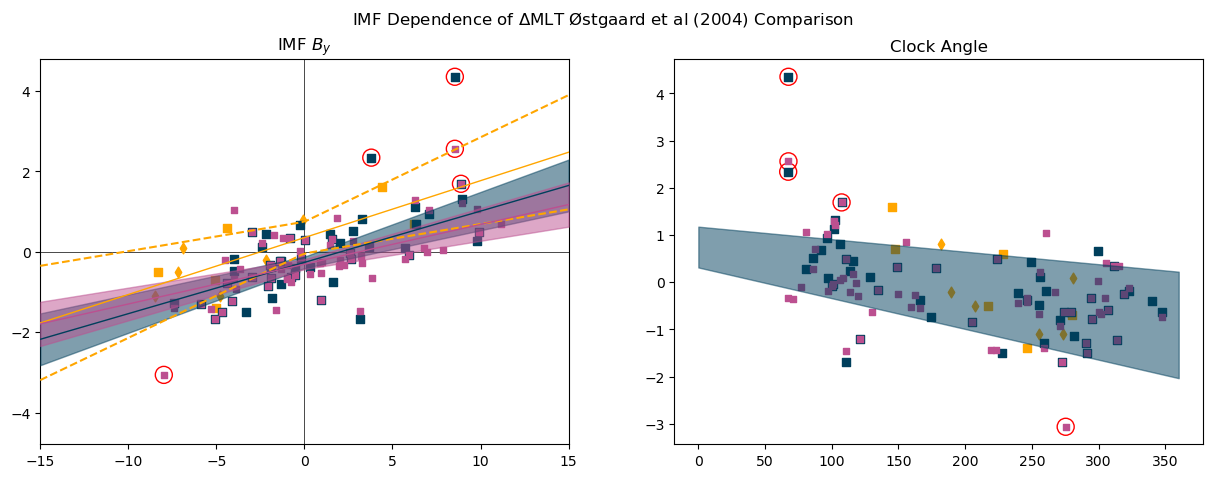

In [21]:
fakefill=ax2.fill_between([0, 0], [0, 0], [0, 0], color='white', alpha=1, label=' '*2)
L= L_Sel1_Clock
ts= ts_Sel1
y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])

ax2.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[0], alpha=.5, 
                 label='90% Confidence\nInterval Selection 1', zorder=110)

fig

##### Selection 2

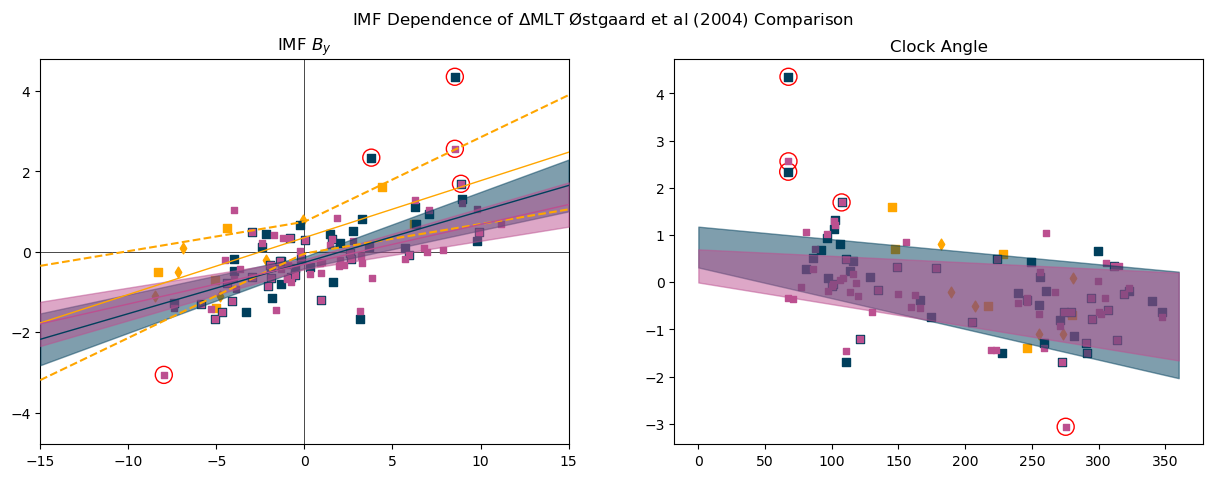

In [22]:
L= L_Sel2_Clock
ts= ts_Sel2

y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])


ax2.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[1], alpha=.5, 
                 label='90% Confidence\nInterval Selection 2', zorder=110)
fig

Østgaard et al (2004)

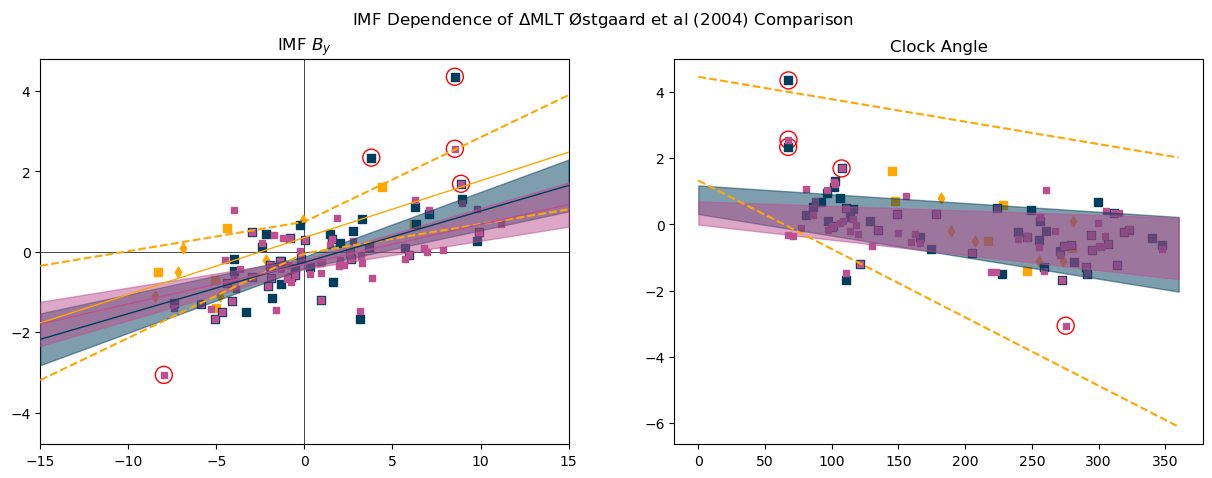

In [23]:
L= L_Øst_Clock
ts= ts_Øst
y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])

ax2.plot(np.linspace(*xlim, 100), np.min(y, axis=0), linestyle='--', color=colors[2], zorder=999)
ax2.plot(np.linspace(*xlim, 100), np.max(y, axis=0), linestyle='--', color=colors[2], zorder=999,
        label='90% Confidence Interval\nØstgaard et al (2004)')
fig

#### Add zero line and set x and y limits

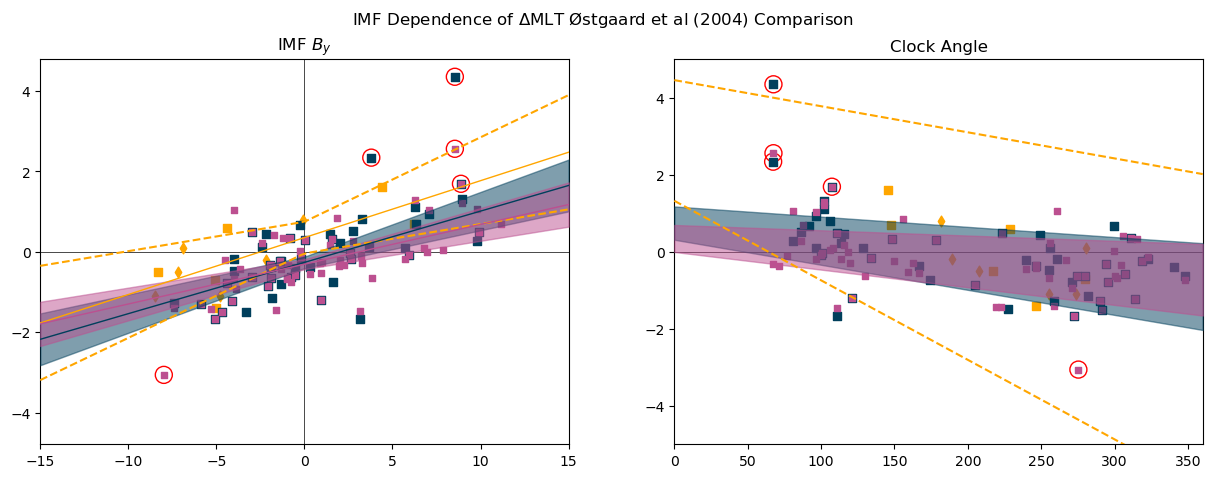

In [24]:
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.axhline(0, color='black', lw=.5, zorder=-1)
fig

### Creating Legends

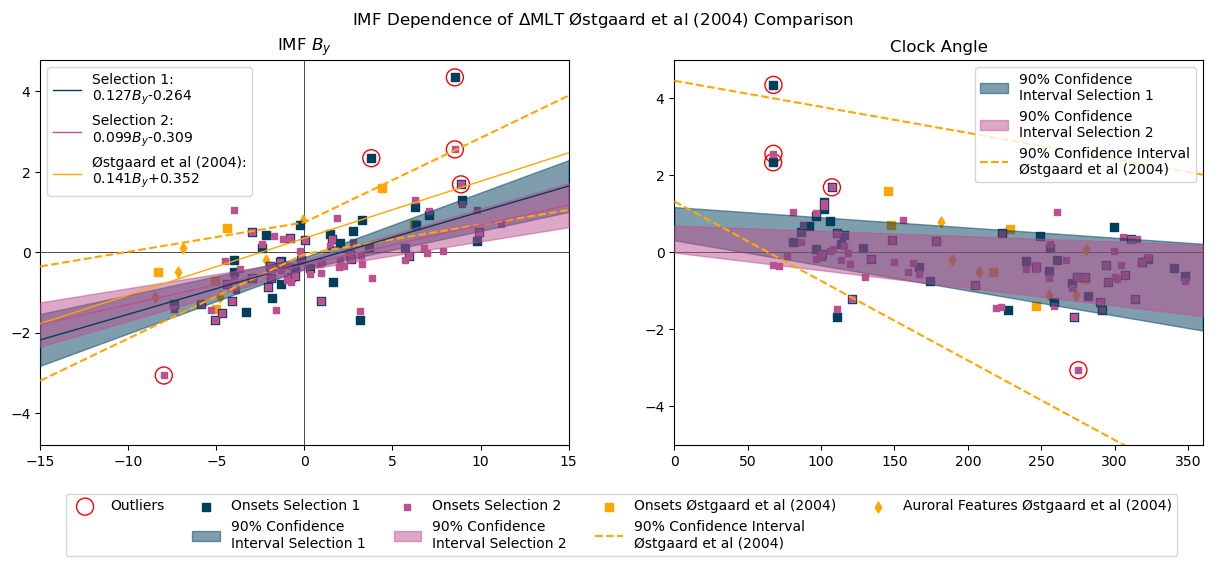

In [25]:
for ax_, loc in zip((ax, ax2), ('upper left', 'upper right')):
    h, l= ax_.get_legend_handles_labels()
    leg=ax_.legend(loc=loc, handles=h[-3:], labels=l[-3:])
    leg.set_zorder(10000)
leg1_ax= fig.add_subplot([.1, 0, .4, .1])
subplot_align(leg1_ax, ax, ax2, dim='x')
leg1_ax.axis('off')
h= np.concatenate([h[i:9:5] for i in range(4)]+[[h[4]]])
l= np.concatenate([l[i:9:5] for i in range(4)]+[[l[4]]])
leg1_ax.legend(loc='center', bbox_to_anchor=(.5, -.5), handles= list(h), labels=  list(l), ncol=5)
fig

### Formatting axes

- Adding minor ticks
- Removing unneccessary axes lines
- moving clock angle ticks to right side

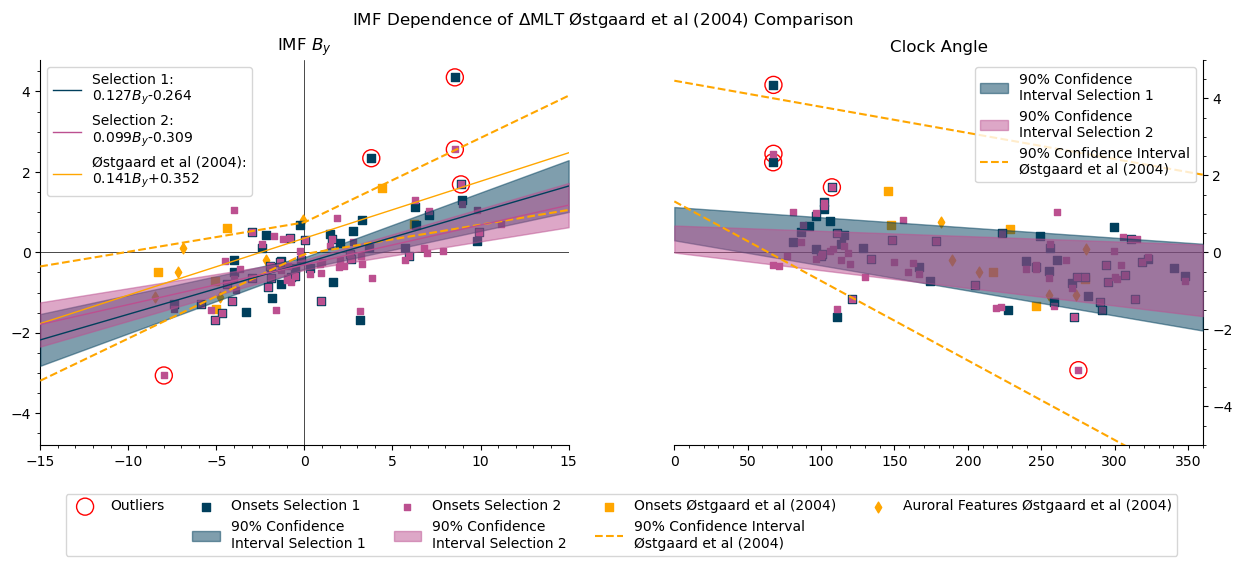

In [26]:
for ax_ in (ax, ax2):
    ax_.spines['top'].set_visible(False)
    ax_.minorticks_on()
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')
fig

### Addding Labels

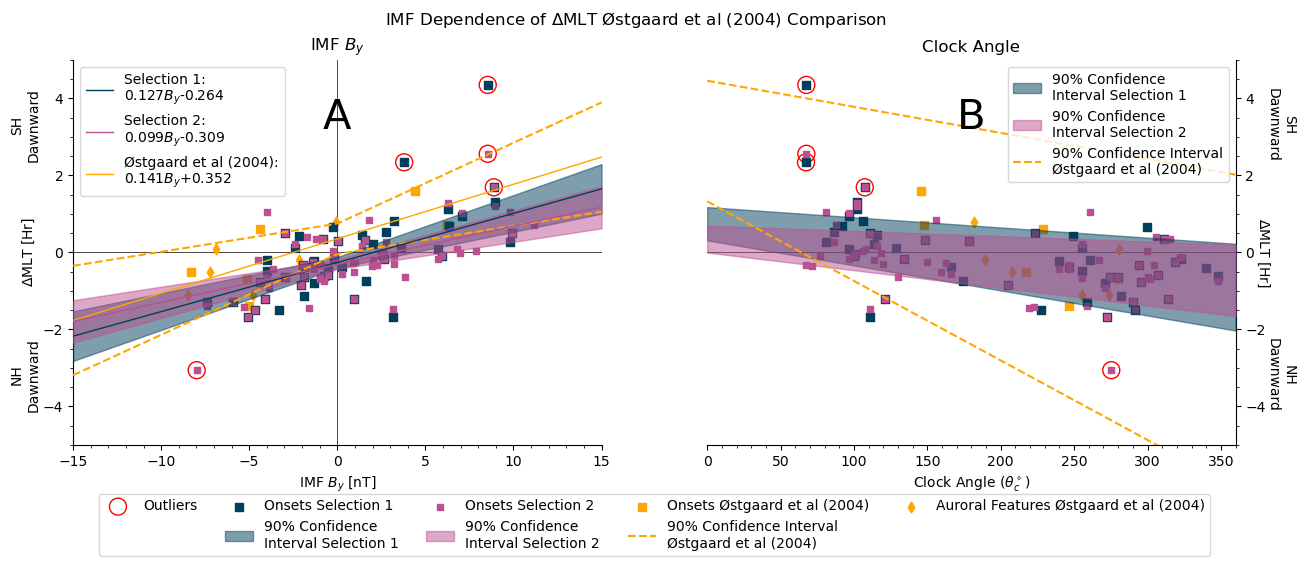

In [27]:
ax.set_ylabel(r'$\Delta$MLT [Hr]', rotation=90)
ax2.set_ylabel(r'$\Delta$MLT [Hr]', rotation=-90)
fig.text(.93, .25, 'NH\nDawnward', rotation=-90, va='center', ha='center')
fig.text(.093, .25, 'NH\nDawnward', rotation=90, va='center', ha='center')

fig.text(.93, .75, 'SH\nDawnward', rotation=-90, va='center', ha='center')
fig.text(.093, .75, 'SH\nDawnward', rotation=90, va='center', ha='center')

ax.sharey(ax2)
ax.set_xlabel(r'IMF $B_y$ [nT]')
ax2.set_xlabel(r'Clock Angle ($\theta_c^\circ$)')

ax.text(0, 3.5, 'A', va='center', ha='center', size=30, zorder=10000)
ax2.text(180, 3.5, 'B', va='center', ha='center', size=30, zorder=10000)
fig